The goal of this analysis is to find the most popular real estate neighborhood in the New York City.

step1: read all the data

In [39]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import DistanceMetric
from sklearn.model_selection import GridSearchCV

In [3]:
import os
import json


import pandas as pd
import numpy as np
#os.chdir("C:/Users/jiang/Documents/kaggle")
#os.chdir("../data/")
import matplotlib.pyplot as plt
train_df = pd.read_json("train.json")


step2: extract the longtitude and latitude info

In [5]:
train_coords = train_df[["listing_id", "latitude", "longitude"]]
lat= []
lon = []
listings = []

for i, j in train_coords.iterrows():
    lat.append(j["latitude"])
    lon.append(j["longitude"])
    listings.append(int(j["listing_id"]))

step3:identify the zipcode of the listing from the lon and lat

In [10]:
from uszipcode import ZipcodeSearchEngine
search = ZipcodeSearchEngine()

res = []
for i in range(len(listings)):
    try:
        res.append([listings[i],search.by_coordinate(lat[i], lon[i], radius=1, returns=1)[0]['Zipcode']])
    except:
        continue
nbd_df = pd.DataFrame(res, columns = ['listing_id','zipcode'])

step4:get the neigborhood info from the csv file

In [30]:
#zip_dir="C:\Users\jiang\Documents\kaggle\zip_n.csv"
zip_dir="../eda/zip_n.csv"
zip_n = pd.read_csv(zip_dir,header=0, names=['zipcode', 'neighborhood'])
zip_n['zipcode'] = zip_n.apply(lambda row: str(row.zipcode), axis=1)

step5:merge data together

In [31]:
train_df = train_df.merge(nbd_df, left_on='listing_id', right_on='listing_id', how='left')
train_df = train_df.merge(zip_n, left_on='zipcode', right_on='zipcode', how='left')  

In [34]:
train_df['interest'] = train_df.interest_level == 'high'
interest_high = train_df.groupby('neighborhood')['interest'].mean()
list_count = train_df.groupby('neighborhood')['neighborhood'].count()

In [36]:
print list_count[:3]
print interest_high[:3]

neighborhood
Albemarle-Kenmore Terrace    197
Arverne                        2
Astoria                      168
Name: neighborhood, dtype: int64
neighborhood
Albemarle-Kenmore Terrace    0.192893
Arverne                      0.500000
Astoria                      0.184524
Name: interest, dtype: float64


step5:print the top 5 neighborhood. There are a few neighborhood with very few listing, which may inflate the ratio of high interest listing. I am only looking at neighborhood with more than 100 listing.

In [33]:
interest_high[list_count > 100].sort_values(ascending=False).head(5)

neighborhood
Kew Gardens             0.283019
Crown Heights North     0.267241
Beverley Square West    0.192893
Flatbush                0.192893
Ditmas Park West        0.192893
Name: interest, dtype: float64

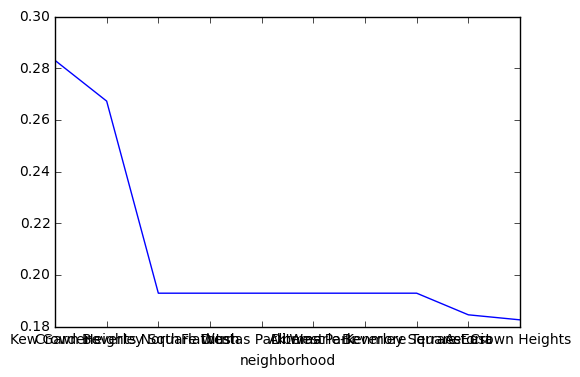

In [40]:
interest_high[list_count > 100].sort_values(ascending=False).head(10).plot()  

## Description analysis

In [42]:
train_df.description.head()

0    A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...
1    A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...
2                                                     
3    Top Top West Village location, beautiful Pre-w...
4    Building Amenities - Garage - Garden - fitness...
Name: description, dtype: object

### CounterVectorizer method

In [44]:
des = CountVectorizer()
des_matrix = des.fit_transform(train_df.description)
des_matrix.shape

(58257, 37823)

In [47]:
LR = LogisticRegression(verbose=3, solver="newton-cg", n_jobs=-1)
LR.fit(des_matrix[:40000], train_df.interest_level[:40000])

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   36.2s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=3, warm_start=False)

In [48]:
LR.score(des_matrix[40000:], train_df.interest_level[40000:])

0.67847948731993213

Print the most import 1 gram key words in description

In [51]:
np.argsort(LR.coef_[0])[::-1]

array([21517,  1258, 20398, ..., 18687, 17436, 22684])

In [28]:
np.array(des.get_feature_names())[np.argsort(LR.coef_[0])[::-1]][:100]

array([u'julio', u'floorsflex', u'daniel', u'snatch', u'tuesday',
       u'bradhurst', u'mdrn', u'adwar', u'josh', u'1750', u'anastasiia',
       u'alex', u'ian', u'lorenzo', u'standing', u'bambi', u'partitioned',
       u'yanell', u'488', u'1900', u'capital', u'222481', u'flawless',
       u'frame', u'graceful', u'straight', u'3668', u'counts',
       u'factoring', u'931', u'afternoon', u'makr', u'clear', u'50ft',
       u'includedno', u'leroy', u'2721273', u'9993', u'stripped', u'hatch',
       u'48th', u'source', u'bahan', u'534', u'anymore',
       u'christiechristie', u'ashowing', u'morton', u'1bathroom', u'tom',
       u'647', u'thisapartment', u'highways', u'evening', u'concourse',
       u'wing', u'1650', u'kingston', u'bad', u'119426', u'franco',
       u'jonathan', u'181', u'concessional', u'walled', u'nassau',
       u'priceunit', u'personal', u'extras', u'nature', u'explore',
       u'appartment', u'christie', u'competitively', u'distinguished',
       u'omar', u'feeblocks'

### Tfidfvectorizer analysis

In [52]:
des_idf = TfidfVectorizer(ngram_range=(1,2), stop_words = 'english')
des_matrix = des_idf.fit_transform(train_df.description)
LR_idf = LogisticRegression(verbose=3, solver="newton-cg", n_jobs=-1)
LR_idf.fit(des_matrix[:40000], train_df.interest_level[:40000])
print LR_idf.score(des_matrix[40000:], train_df.interest_level[40000:])

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.5s finished


0.697759763378


In [53]:
print np.array(des_idf.get_feature_names())[np.argsort(LR_idf.coef_[0])[::-1]][:100]

[u'rent' u'included' u'floor apartment' u'studio' u'strong' u'income'
 u'ditmas' u'ditmas park' u'utilities included' u'new' u'fee' u'flex'
 u'utilities' u'asap' u'3rd' u'personal tour' u'sunny' u'astoria'
 u'light br' u'note' u'situated' u'true' u'br open' u'value' u'renovations'
 u'includes' u'info coming' u'gut' u'new hardwood' u'set personal' u'away'
 u'credit' u'available 2016' u'queen' u'close shopping' u'best'
 u'room kitchen' u'home available' u'share' u'renovated' u'bedrooms'
 u'text' u'located heart' u'apt photos' u'clean' u'crown heights'
 u'spacious sunny' u'great price' u'jamesia' u'daniel' u'ave' u'tour today'
 u'fee unit' u'modern studio' u'actual apt' u'email' u'exclusive viewing'
 u'deal' u'viewing contact' u'perfect' u'spacious modern' u'text set'
 u'late' u'2br' u'steps' u'table' u'queen bed' u'483 6814' u'6814' u'super'
 u'excellent location' u'gut renovated' u'info' u'charming' u'crown'
 u'spacious' u'wing' u'building maintained' u'br center' u'new floors'
 u'price

### SVD analysis
* shows that we only need 1 SVD?

In [ ]:
des_idf = TfidfVectorizer(ngram_range=(1,2), stop_words = 'english')
des_matrix = des_idf.fit_transform(train_df.description)

for i in np.arange(10)+1:
    svd = TruncatedSVD(n_components=i)
    new_des = svd.fit_transform(des_matrix)
    LR_idf = LogisticRegression(verbose=3, solver="newton-cg", n_jobs=-1)
    LR_idf.fit(new_des[:40000], train_df.interest_level[:40000])
    print LR_idf.score(new_des[40000:], train_df.interest_level[40000:])

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


0.688174398861


In [17]:
des_idf = TfidfVectorizer(ngram_range=(2,2), stop_words = 'english')
des_matrix = des_idf.fit_transform(train_df.description)
svd = TruncatedSVD(n_components=10)
svd.fit_transform(des_matrix)
print svd.explained_variance_ratio_

[ 0.01084967  0.01418261  0.01236317  0.00937116  0.00724798  0.00603212
  0.00373745  0.00326175  0.00321599  0.0028372 ]


Filter out all the digits in the description

In [18]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

In [73]:
des_idf = TfidfVectorizer(ngram_range=(2,2), stop_words = 'english', tokenizer=tokenizer.tokenize)
des_matrix = des_idf.fit_transform(train_df.description)
LR_idf = LogisticRegression()
LR_idf.fit(des_matrix[:40000], train_df.interest_level[:40000])
print LR_idf.score(des_matrix[40000:], train_df.interest_level[40000:])

0.696828613682


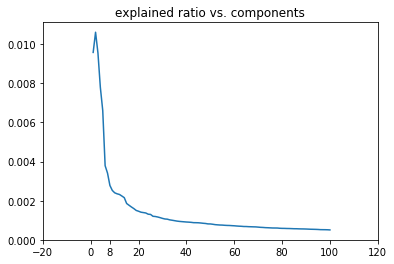

In [75]:
svd = TruncatedSVD(n_components=100)
svd.fit_transform(des_matrix)
plt.plot(np.arange(100)+1,svd.explained_variance_ratio_)
extraticks=[8]
plt.xticks(list(plt.xticks()[0]) + extraticks)
plt.title("explained ratio vs. components")
plt.show()

In [78]:
svd = TruncatedSVD(n_components=8)
description_df = pd.DataFrame(svd.fit_transform(des_matrix))

In [20]:
np.array(des_idf.get_feature_names())[np.argsort(LR_idf.coef_[0])[::-1]][:100]

array([u'utilities included', u'water included', u'heat water',
       u'eat kitchen', u'exclusive viewing', u'close shopping',
       u'personal tour', u'included rent', u'good credit', u'true bedroom',
       u'queen bed', u'gut renovated', u'br center', u'viewing contact',
       u'new hardwood', u'floor apartment', u'true br',
       u'excellent location', u'fee unit', u'heat hot', u'th ave',
       u'set personal', u'apt photos', u'rent stabilized', u'won t',
       u'great price', u'tour today', u'hot water', u'actual apt',
       u'ceramic tiled', u'free text', u'open house', u'contact eli',
       u'new floors', u'sorry pets', u'text set', u'kew gardens',
       u'queen beds', u'train station', u'live super', u'br kw',
       u'spacious sunny', u'text jackie', u'room kitchen', u'steps away',
       u'br bedrooms', u'jackie m', u'br exclusive', u'lower east',
       u'e th', u's appliances', u'kitchen bathroom', u'huge studio',
       u'text anytime', u'unit comes', u'text natha

Neighborhood factor prediction

In [23]:
train_nb = pd.get_dummies(train_df.neighborhood)

In [24]:
LR_nb = LogisticRegression()
LR_nb.fit(train_nb[:40000], train_df.interest_level[:40000])
print LR_nb.score(train_nb[40000:], train_df.interest_level[40000:])

0.68850303993


## City columns

In [102]:
city = []
for i in range(len(listings)):
    try:
        city.append([listings[i],search.by_coordinate(lat[i], lon[i], radius=1, returns=1)[0]['City']])
    except:
        continue
city_df = pd.DataFrame(city, columns = ['listing_id','city'])

In [123]:
city_dummy = pd.get_dummies(city_df)
train_df_list = pd.DataFrame(train_df['listing_id'])
train_df_list = train_df_list.merge(city_dummy, left_on='listing_id', right_on='listing_id', how='left')

In [135]:
train_df_list=train_df_list.fillna(0)

In [124]:
del train_df_list['listing_id']

## Features

In [28]:
import scipy.sparse as sp
feature_list = []
for i in train_df.features:
    feature_list.extend(i)
names = list(set(feature_list))

In [29]:
voc2id = dict(zip(names, range(len(names))))

convert features to sparse matrix

In [263]:
rows, cols, vals = [], [], []
for r, d in enumerate(train_df.features):
    for e in d:
        if voc2id.get(e) is not None:
            rows.append(r)
            cols.append(voc2id[e])
            vals.append(1)
features = sp.csr_matrix((vals, (rows, cols)))

In [31]:
LR_features = LogisticRegression()
LR_features.fit(features[:40000], train_df.interest_level[:40000])
print LR_features.score(features[40000:], train_df.interest_level[40000:])

0.689872377718


In [33]:
for i in np.arange(10)+1:
    svd = TruncatedSVD(n_components=i)
    new_des = svd.fit_transform(features)
    LR_idf = LogisticRegression()
    LR_idf.fit(new_des[:40000], train_df.interest_level[:40000])
    print LR_idf.score(new_des[40000:], train_df.interest_level[40000:])

0.688338719395
0.688338719395
0.688338719395
0.688010078326
0.688064851838
0.688174398861
0.688776907488
0.689324642603
0.689324642603
0.688612586953


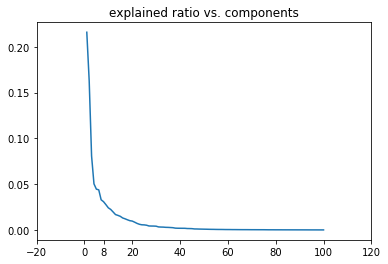

In [46]:
svd = TruncatedSVD(n_components=100)
svd.fit_transform(features)
plt.plot(np.arange(100)+1,svd.explained_variance_ratio_)
extraticks=[8]
plt.xticks(list(plt.xticks()[0]) + extraticks)
plt.title("explained ratio vs. components")
plt.show()

In [67]:
svd = TruncatedSVD(n_components=8)
features_svd = pd.DataFrame(svd.fit_transform(features))

Combine all columns

In [83]:
train_df.columns

Index([      u'bathrooms',        u'bedrooms',     u'building_id',
               u'created',     u'description', u'display_address',
              u'features',  u'interest_level',        u'latitude',
            u'listing_id',       u'longitude',      u'manager_id',
                u'photos',           u'price',  u'street_address',
             u'zipcode_x',    u'neighborhood',       u'zipcode_y',
               u'zipcode'],
      dtype='object')

In [141]:
neighborhood_df = pd.get_dummies(train_df.neighborhood)

In [142]:
useful_df = train_df[['bathrooms','bedrooms','price']]
frames = [useful_df, features_svd, description_df,train_df_list,neighborhood_df]
result = pd.concat(frames, axis=1)
result = result.fillna(0)

Fitting model

In [143]:
xgb = GradientBoostingClassifier()
xgb.fit(result[:40000], train_df.interest_level[:40000])
xgb.score(result[40000:],train_df.interest_level[40000:])

0.73204999999999998

In [144]:
result.shape

(58257, 346)

## Another way of neigborhood code

I get the following neighborhood names from the Renthop nyc website. The latitude and longitude of the neigborhood is gotten with the geopy.geocodes. The correponsing neighborhood is returned by calculated the distance between the listing building and the center of the neigborhood.

I notice there are some wrong records in the records, which give me a location in Chicago or even farther. I remove all listing with distance greater than 10.

In [146]:
from geopy.geocoders import Nominatim

In [150]:
m_neighborhoods = ['Battery Park City','Bowery','Chinatown','Civic Center','East Village','Financial District',
                   'Greenwich Village','Little Italy','Lower East Side','NoHo','NoLita','SoHo','Tribeca','Two Bridges',
                   'West Village','Chelsea','Flatiron District','Garment District','Gramercy Park',"Hell's Kitchen",'Kips Bay',
                   'Koreatown','Midtown East','Murray Hill','NoMad','Stuyvesant Town - Peter Cooper Village','Theater District',
                   'Central Harlem','Central Park','East Harlem','Inwood','Upper East Side','Upper West Side',
                   'Washington Heights','West Harlem','Randalls-Wards Island','Roosevelt Island']
        
b_neighborhoods = ['Bedford-Stuyvesant','Bushwick','Greenpoint','Williamsburg','Boerum Hill','Carroll Gardens','Cobble Hill',
                   'Gowanus','Greenwood Heights','Park Slope','Prospect Park','Red Hook','Sunset Park','Windsor Terrace',
                   'Crown Heights','East Flatbush','Flatbush','Kensington','Midwood','Ocean Hill','Brooklyn Heights',
                   'Brooklyn Navy Yard','Clinton Hill','DUMBO','Downtown Brooklyn','Fort Greene','Prospect Heights',
                   'Vinegar Hill','Bath Beach','Bay Ridge','Bensonhurst','Borough Park','Dyker Heights','Mapleton',
                   'Brighton Beach','Coney Island','Gravesend','Sheepshead Bay','Brownsville','Canarsie','Cypress Hills',
                   'East New York','Bergen Beach','Flatlands','Floyd Bennett Airfield','Marine Park','Mill Basin']

q_neighborhoods = ['Astoria','Corona','East Elmhurst','Elmhurst','Forest Hills','Glendale','Jackson Heights','Long Island City',
                   'Maspeth','Middle Village','Rego Park','Ridgewood','Sunnyside','Woodside','Auburndale','Bayside',
                   'College Point','Flushing','Flushing Meadows-Corona Park','Fresh Meadows','Glen Oaks','Kew Gardens',
                   'Kew Gardens Hills','Whitestone','Briarwood','Hollis','Holliswood','Jamaica','Jamaica Estates',
                   'Jamaica Hills','South Jamaica','St. Albans','Forest Park','Howard Beach','Ozone Park','Richmond Hill',
                   'South Ozone Park','Woodhaven','Far Rockaway','Rockaway Beach']

s_neighborhoods =  ['East Shore','Mid-Island','North Shore','South Shore']

bx_neighborhoods = ['Bedford Park','Belmont','Bronx Park','Concourse','Concourse Village','East Tremont','Fordham Heights',
                    'Fordham Manor','Highbridge','Hunts Point','Kingsbridge','Longwood','Marble Hill','Morris Heights',
                    'Morrisania','Mott Haven','Mount Eden','Mount Hope','Norwood','Riverdale','University Heights',
                    'Van Cortlandt Park','West Farms','Allerton','Clason Point','Morris Park','Parkchester','Pelham Bay',
                    'Pelham Parkway','Throgs Neck','Unionport','Van Nest','Wakefield','Westchester Village','Williamsbridge',
                    'Woodlawn Heights']

nj_neighborhoods = ['Bergen - Lafayette',
                    'Greenville','Historic Downtown','McGinley Square','The Heights','The Waterfront','West Side']

In [157]:
neighborhood_list = ['m_neighborhoods','b_neighborhoods','q_neighborhoods','s_neighborhoods','bx_neighborhoods','nj_neighborhoods']
n_dict = {'m_neighborhoods':'manhattan','b_neighborhoods':'brooklyn','q_neighborhoods':'queens',
          's_neighborhoods':'staten island','bx_neighborhoods':'bronx','nj_neighborhoods':'new jersey'}

Some neighborhoods cannot be automatically located through geopy. I searched it out in Google and fill it out mannualy.

In [161]:
neighborhood_dict= {}
for n_list in neighborhood_list:
    for n in eval(n_list):
        geolocator = Nominatim()
        location = geolocator.geocode(n+" "+n_dict[n_list])
        try:
            neighborhood_dict[n]=(location.latitude, location.longitude)
        except:
            print n_list +":"+ n
            continue

m_neighborhoods:NoLita
m_neighborhoods:Two Bridges
m_neighborhoods:Flatiron District
m_neighborhoods:Garment District
m_neighborhoods:Stuyvesant Town - Peter Cooper Village
m_neighborhoods:Randalls-Wards Island
b_neighborhoods:Floyd Bennett Airfield
q_neighborhoods:Jamaica Hills
s_neighborhoods:East Shore
s_neighborhoods:Mid-Island
s_neighborhoods:North Shore
s_neighborhoods:South Shore
bx_neighborhoods:Westchester Village
nj_neighborhoods:Bergen - Lafayette
nj_neighborhoods:Historic Downtown
nj_neighborhoods:McGinley Square
nj_neighborhoods:West Side


In [163]:
neighborhood_dict['Nolita'] = (40.7230413,-73.9948607)
neighborhood_dict['Two Bridges'] = (40.71074689999999,-73.99696)
neighborhood_dict['Flatiron District'] = (40.74008300000001,-73.99034890000001)
neighborhood_dict['Garment District'] = (40.7547072,-73.99163420000002)
neighborhood_dict['Stuyvesant Town - Peter Cooper Village'] = (40.7316903,-73.97784939999997)
neighborhood_dict['Randalls-Wards Island'] = (40.7932271,-73.92128579999996)
neighborhood_dict['Floyd Bennett Airfield'] = (40.5910174,-73.8906091)
neighborhood_dict['Jamaica Hills'] = (40.71280290000001,-73.79926339999997)
neighborhood_dict['East Shore'] = (40.606221,-74.06419489999996)
neighborhood_dict['Mid-Island'] = (40.5993847,-74.17931770000001)
neighborhood_dict['North Shore'] =(40.62604414772478,-74.12667847936973)
neighborhood_dict['South Shore'] = (40.531910867376595,-74.21559907263145)
neighborhood_dict['Westchester Village'] = (40.8407103,-73.8473591)
neighborhood_dict['Bergen - Lafayette'] =(40.71114639999999,-74.07407289999998)
neighborhood_dict['Historic Downtown'] =(40.71114639999999,-74.07407289999998)
neighborhood_dict['McGinley Square'] = (40.7241223,-74.06966729999999)
neighborhood_dict['West Side'] =(40.7247507,-74.08288390000001)

In [168]:
neighborhood_df = pd.Series(neighborhood_dict)

Calculate the distance betweent the building and the center of the neighborhood

In [244]:
dist = DistanceMetric.get_metric('euclidean')
X = list(neighborhood_df)

min_distance = np.zeros(train_df.shape[0])
min_index = []
count = 0
for listing in np.array(train_df[['latitude','longitude']]) :   
    min_distance[count] = np.min(dist.pairwise(X,[listing]), axis = 0)
    if np.min(dist.pairwise(X,[listing]), axis = 0) < 10:
        min_index.append(neighborhood_df.index[np.argmin(dist.pairwise(X,[listing]))])
    else:
        min_index.append(np.nan)
    count += 1
min_index = np.array(min_index)

In [251]:
n_df = pd.get_dummies(min_index)
n_df = n_df.fillna(0)

A brief plot of the distance (only show 16 listing with maxium distance)

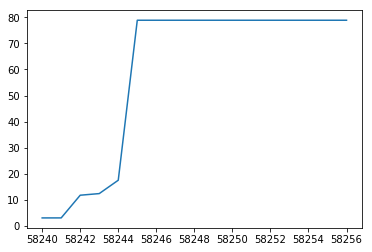

In [241]:
plt.plot(range(train_df.shape[0])[58240:],min_distance[58240:])
plt.show()

## Trying differnt kinds of input and see the accuaracy
I try to use gridsearch for xgb. However, it is extremely slow , so I just try different combinations of the parameters

In [278]:
frames = [useful_df, features_svd, description_df]
result = pd.concat(frames, axis=1)
result = result.fillna(0)
xgb = GradientBoostingClassifier()
xgb.fit(result[:40000], train_df.interest_level[:40000])
xgb.score(result[40000:],train_df.interest_level[40000:])

0.7120556498877143

In [279]:
frames = [useful_df, features_svd,n_df]
result = pd.concat(frames, axis=1)
result = result.fillna(0)
xgb = GradientBoostingClassifier()
xgb.fit(result[:40000], train_df.interest_level[:40000])
xgb.score(result[40000:],train_df.interest_level[40000:])

0.71030289751875997

In [277]:
frames = [useful_df, features_svd, n_df,description_df]
result = pd.concat(frames, axis=1)
result = result.fillna(0)
xgb = GradientBoostingClassifier()
xgb.fit(result[:40000], train_df.interest_level[:40000])
xgb.score(result[40000:],train_df.interest_level[40000:])

0.71232951744536344

In [283]:
frames = [useful_df, features_svd, n_df,description_df]
result = pd.concat(frames, axis=1)
result = result.fillna(0)
xgb = GradientBoostingClassifier(max_depth = 10)
xgb.fit(result[:40000], train_df.interest_level[:40000])
xgb.score(result[40000:],train_df.interest_level[40000:])

0.72103850577860551

In [284]:
frames = [useful_df, features_svd, n_df,description_df]
result = pd.concat(frames, axis=1)
result = result.fillna(0)
xgb = GradientBoostingClassifier(n_estimators = 300)
xgb.fit(result[:40000], train_df.interest_level[:40000])
xgb.score(result[40000:],train_df.interest_level[40000:])

0.7166566248562195